In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
import os

In [2]:
img_height = 256
img_width = 256
channels = 3
batch_size = 16
img_height = 256
img_width = 256
channels = 3
batch_size = 16

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [11]:
training_set = train_datagen.flow_from_directory(
    'smalltrain',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

Found 12247 images belonging to 1 classes.


In [12]:
validation_set = train_datagen.flow_from_directory(
    'smalltest',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)

Found 1832 images belonging to 1 classes.


In [13]:
# Define the autoencoder
input_model = Input(shape=(img_height, img_width, channels))

# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

# Create model object
autoencoder = Model(input_model, output, name='autoencoder')

# Compile the model
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3))

# Fit the model
history = autoencoder.fit(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=1,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [ModelCheckpoint('models/image_autoencoder.h5', 
                                       monitor='val_loss', 
                                       verbose=0, 
                                       save_best_only=True, 
                                       save_weights_only=False)])

C:\Users\saith\AppData\Local\Temp\ipykernel_21492\1732973330.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(


765/765 [==============================] - 5006s 7s/step - loss: 0.0385 - val_loss: 0.0382


In [4]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_2 (Batc  (None, 256, 256, 64)     256       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 4194304)           0         
                                                                 
 latent_space (Dense)        (None, 16)                67108880  
                                                       

In [24]:
latent_space_model = Model(autoencoder.input, autoencoder.get_layer('latent_space').output)

In [26]:
# Load all images and predict them with the latent space model
X = []
indices = []

for i in tqdm(range(len(os.listdir('smalltest/smalltest')))):
  try:
    img_name = os.listdir('smalltest/smalltest')[i]
    img = load_img('smalltest/smalltest/{}'.format(img_name), 
                   target_size = (256, 256))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = latent_space_model.predict(img)
    pred = np.resize(pred, (16))
    X.append(pred)
    indices.append(img_name)

  except Exception as e:
    print(img_name)
    print(e)

    # Export the embeddings
embeddings = {'indices': indices, 'features': np.array(X)}
pickle.dump(embeddings, 
            open('image_embeddings.pickle', 'wb'))

C:\Users\saith\AppData\Local\Temp\ipykernel_21492\28193628.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(os.listdir('smalltest/smalltest')))):


  0%|          | 0/9160 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


In [ ]:
def eucledian_distance(x,y):
  eucl_dist = np.linalg.norm(x - y)
  return eucl_dist

def category_similarity(x,y):
  return SequenceMatcher(None, x, y).ratio()

In [28]:
# Load embeddings
embeddings = pickle.load(open('image_embeddings.pickle', 'rb'))

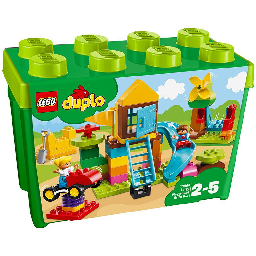

In [47]:
img_name = os.listdir('smalltest/smalltest')[12]
img = load_img('smalltest/smalltest/{}'.format(img_name), target_size=(256, 256))
img

1/1 [==============================] - 0s 55ms/step


C:\Users\saith\AppData\Local\Temp\ipykernel_21492\3232816026.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(embeddings['indices']))):


  0%|          | 0/9160 [00:00<?, ?it/s]

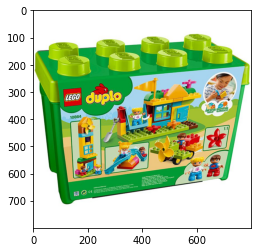

Euclidean Distance: 1450.805419921875


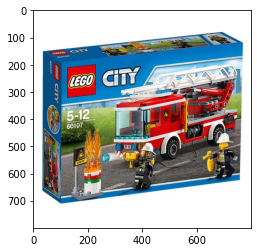

Euclidean Distance: 2420.270751953125


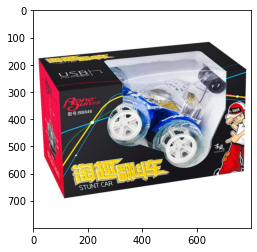

Euclidean Distance: 2764.017822265625


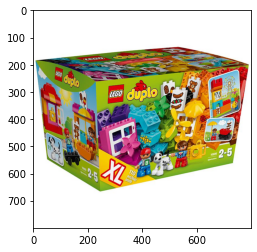

Euclidean Distance: 2779.656982421875


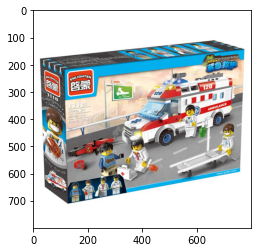

Euclidean Distance: 2793.153076171875


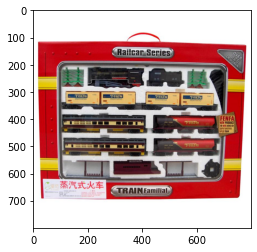

Euclidean Distance: 2908.2236328125


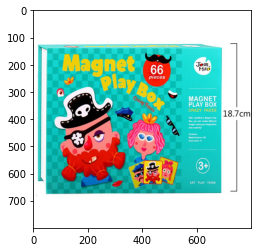

Euclidean Distance: 2974.149169921875


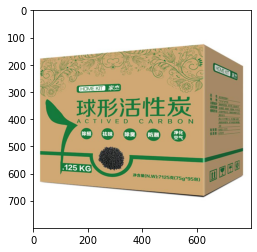

Euclidean Distance: 3072.65087890625


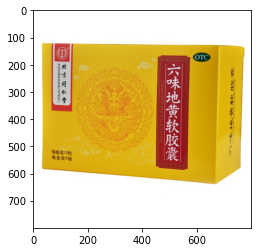

Euclidean Distance: 3082.73779296875


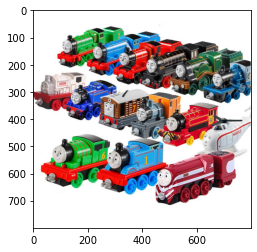

Euclidean Distance: 3251.380615234375


In [48]:
# Calculate eucledian distance
img_similarity = []
cat_similarity = []

# Get actual image embedding
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))

for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity})


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)

# Show 10 first similar images
for i in range(10):
  image = load_img('smalltest/smalltest/{}'.format(imgs_result['img'].values[i]))
  
  # Show image
  plt.imshow(image)
  plt.show()
  print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))